In [1]:
import sys
sys.path.append('../')
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from models.modular_compositional_models import get_sequential_model_effects
from domains.synthetic_data_sampler import SyntheticDataSampler
from models.MoE import *
from models.utils import *
from main_functions import *
warnings.filterwarnings('ignore')



In [2]:
args = parse_arguments()
test_size = 0.2
main_dir, csv_path, obs_data_path, scaler_path = setup_directories(args)
# module_function_types = ["logarithmic", "quadratic", "linear"]
# module_function_types = ["polyval"] * args.num_modules
# module_function_types = [f"f{i+1}" for i in range(args.num_modules)]
# module_function_types = ["linear", "quadratic", "quadratic"]
module_function_types = ["linear"] * args.num_modules
sampler = SyntheticDataSampler(args.num_modules, args.num_feature_dimensions, args.composition_type, 
                                args.fixed_structure, args.num_modules, args.num_samples, args.seed, 
                                args.data_dist, module_function_types=module_function_types, resample=args.resample,
                                heterogeneity=args.heterogeneity, covariates_shared=args.covariates_shared, 
                                use_subset_features=args.use_subset_features, systematic=args.systematic, 
                                run_env=args.run_env, noise=0)

# first sample the data and prepare it
data, df_sampled = simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path, test_size=test_size, test_on_last_depth=True)
if args.composition_type == "hierarchical":
    # do one hot encoding for the order of modules
    # data = pd.concat([data, pd.get_dummies(data["order_of_modules"], prefix="module_order")], axis=1)
    # df_sampled = pd.concat([df_sampled, pd.get_dummies(df_sampled["order_of_modules"], prefix="module_order")], axis=1)
    # order_of_modules is a string "2_3_1", convert it to a list [2, 3, 1] and make it separate columns
    data["order_of_modules"] = data["order_of_modules"].apply(lambda x: [int(i) for i in x.split("_")])
    data = pd.concat([data, pd.DataFrame(data["order_of_modules"].to_list(), columns=[f"module_{i+1}_order" for i in range(args.num_modules)])], axis=1)

    df_sampled["order_of_modules"] = df_sampled["order_of_modules"].apply(lambda x: [int(i) for i in x.split("_")])
    df_sampled = pd.concat([df_sampled, pd.DataFrame(df_sampled["order_of_modules"].to_list(), columns=[f"module_{i+1}_order" for i in range(args.num_modules)])], axis=1)

    # get the order of modules per query_id
    module_order = {}
    for qid, order in zip(df_sampled["query_id"], df_sampled["order_of_modules"]):
        module_order[qid] = order

    # # drop the order_of_modules column
    data.drop(columns=["order_of_modules"], inplace=True)
    df_sampled.drop(columns=["order_of_modules"], inplace=True)

    if args.systematic:
        # replace NaN module orders with 0
        for i in range(1, args.num_modules + 1):
            data[f"module_{i}_order"].fillna(0, inplace=True)
            df_sampled[f"module_{i}_order"].fillna(0, inplace=True)
# Load train and test qids
train_qids, test_qids = load_train_test_qids(csv_path, args)

covariates = [x for x in df_sampled.columns if "feature_0" in x] if args.covariates_shared else [x for x in df_sampled.columns if "feature" in x]

    # remove any output features
    
if args.systematic:
    covariates += [x for x in df_sampled.columns if "num" in x]

if args.composition_type == "hierarchical":
    covariates += [x for x in df_sampled.columns if "order" in x]
    
    covariates = [x for x in covariates if "output" not in x]

if args.model_misspecification:
    covariates = [x for x in covariates if "feature_0" not in x]


# Scale data
if args.scale:
    create_module_scalers(csv_path, obs_data_path, scaler_path, train_qids, args.bias_strength, composition_type=args.composition_type)
    data, df_sampled = scale_df(data, df_sampled, scaler_path, csv_path, composition_type=args.composition_type, covariates=covariates)

# Load train and test data
train_df, test_df, train_qids, test_qids = load_train_test_data(csv_path, args, df_sampled)

train_df, test_df = process_shared_covariates_row_wise(train_df, test_df, args)
# covariates = [x for x in train_df.columns if "feature" or "order" in x and "output" not in x]
T0_trees = {}
# index trees by query_id
for tree in sampler.processed_trees_0:
    T0_trees[tree["query_id"]] = tree

T1_trees = {}
# index trees by query_id
for tree in sampler.processed_trees_1:
    T1_trees[tree["query_id"]] = tree

# As we have same structure across the query_id, we need only one tree to get the structure.

print(f"Training data shape: {train_df.shape}")
print("Covaariates: ", covariates)
treatment, outcome = "treatment_id", "query_output"

gt_effects_test = get_ground_truth_effects(data, test_qids)
gt_effects_train = get_ground_truth_effects(data, train_qids)


model_effects_train = {}
model_effects_test = {}

input_dim = len(covariates)
if input_dim < args.hidden_dim and args.covariates_shared:
    hidden_dim = args.hidden_dim 
else:
    hidden_dim = (input_dim + 1)*2
models = {
    "Baseline": BaselineModel if args.underlying_model_class == "MLP" else BaselineLinearModel,
    # "MoE": MoE if args.underlying_model_class == "MLP" else MoELinear
}

results = {}

num_modules:  3
Reinitializing path 0
Reinitializing path 1
Reinitializing csv folder
Resampling data
Generating input trees
Generating input trees
Number of input trees generated: 10000
Simulating potential outcomes for treatment 0
{'w': [0.11574124383803737, 0.9024159404622326, 0.35637505072652653, 0.36907873971306215, 0.8128308345898865]}
Simulating potential outcomes for treatment 1
{'w': [0.6178652670081114, 0.22627756652732428, 0.24244545019367097, 0.15620061327531412, 0.6181785209754102]}
Processing trees and creating csvs here:  /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/csvs/fixed_structure_True_outcomes_hierarchical_systematic_False
Writing CSV data to files for each module.
8000 2000
Training data shape: (8000, 19)
Covaariates:  ['module_1_feature_feature_0', 'module_2_feature_feature_0', 'module_3_feature_feature_0', 'module_1_order', 'module_2_order', 'module_3_order']


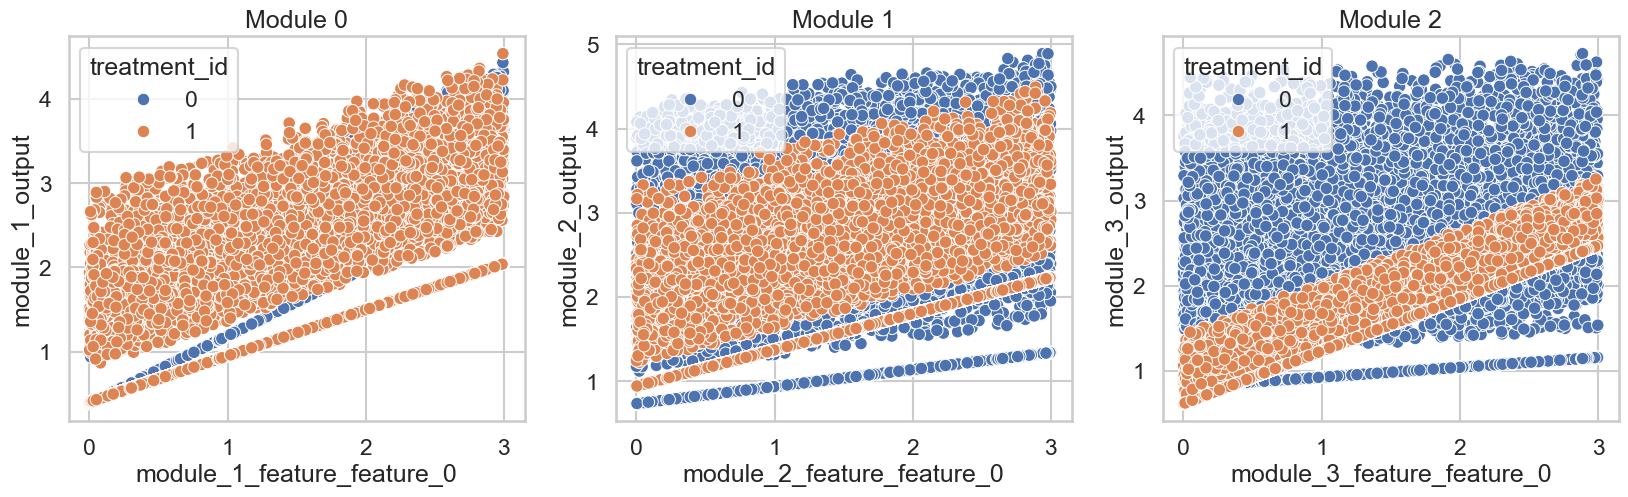

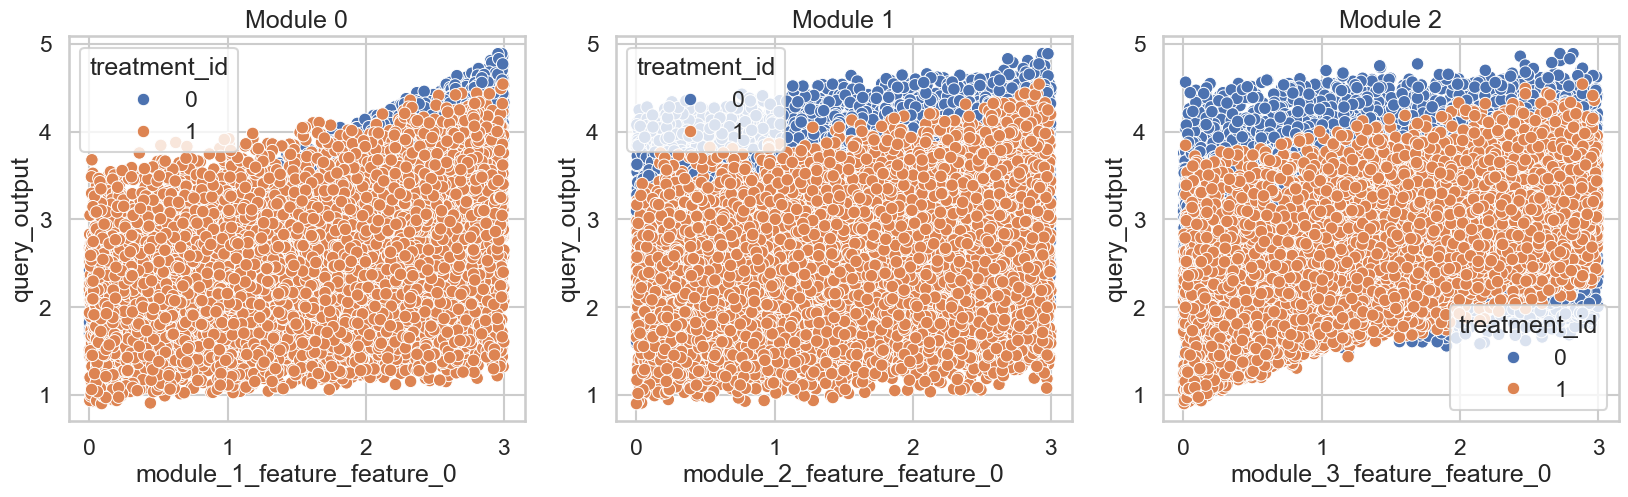

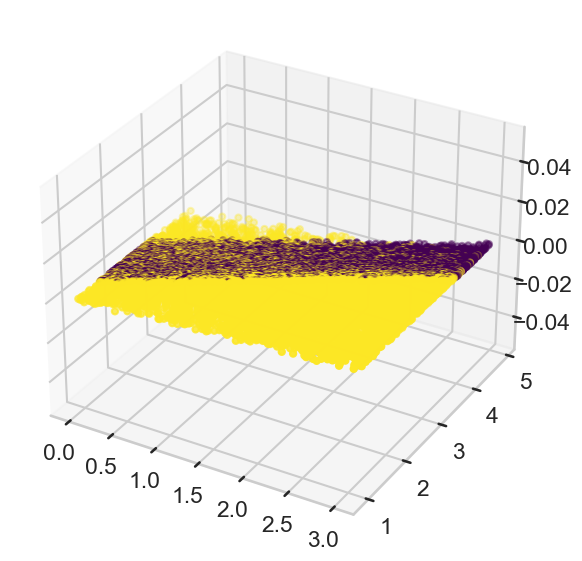

In [3]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = args.num_modules
fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["module_1_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



In [5]:
jsons_0 = T0_trees
jsons_1 = T1_trees
scale = False
epochs = 20
from models.modular_compositional_models import split_modular_data
train_data, test_data, module_files = split_modular_data(csv_path, obs_data_path, train_qids, test_qids, scaler_path, args.scale, args.bias_strength, args.composition_type)
# filter train_data to only include treatmen 0
# for k, v in train_data.items():
#     train_data[k] = v[v["treatment_id"] == 0]
# train_qids = train_data["module_1.csv"]["query_id"].unique()
model, scalers = create_modular_model(train_data, jsons_0, jsons_1, scale=scale)
    
# Prepare data for training (now includes scaling)
X, y, json_structures = prepare_data_for_training(train_data, jsons_0, jsons_1, train_qids, scalers, scale=scale)

# Train the model
train_end_to_end_modular_model(model, X, y, json_structures, epochs, args.batch_size,lr=0.001)



Epoch 1/20, Loss: 2.2116
Epoch 10/20, Loss: 0.0011
Epoch 20/20, Loss: 0.0004


ModularModel()

In [54]:
dataset = ModularDataset(X, y, json_structures)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=custom_collate)
batch_X, batch_y, batch_structures = next(iter(dataloader))

In [6]:
# Make predictions (update this function to use scalers)
test_predictions = predict_end_to_end_modular_model(model, test_data, jsons_0, jsons_1, scalers)
    

In [7]:
# Get ground truth effects
test_ground_truth = get_ground_truth_effects_jsons(jsons_0, jsons_1, test_qids)

# Prepare and return results
test_results = prepare_results(test_qids, test_predictions, test_ground_truth)

In [8]:
test_results

,query_id,ground_truth_effect,estimated_effect
0,8,-0.993143,-1.023740
1,12,-0.243482,-0.261730
2,13,-0.236069,-0.233660
3,15,-1.238156,-1.266825
4,23,-1.591382,-1.560428
...,...,...,...
1995,9985,-0.381780,-0.374933
1996,9987,-0.534146,-0.501834
1997,9991,0.103724,0.125053
1998,9992,-0.031537,0.002888


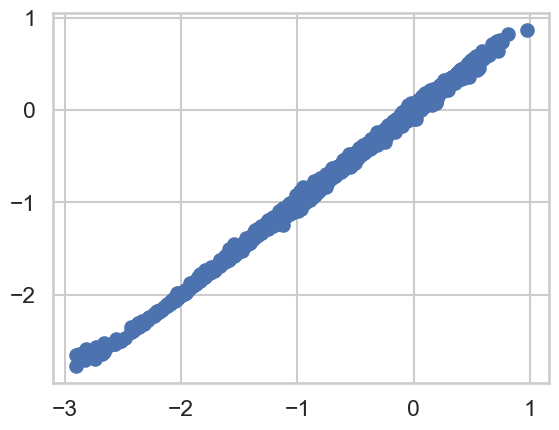

In [9]:
plt.scatter(test_results["ground_truth_effect"], test_results["estimated_effect"])